In [5]:
%pylab inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# %config InlineBackend.figure_format = 'svg'
# seaborn.set_style("white")

Populating the interactive namespace from numpy and matplotlib


In [6]:
df1 = pd.read_csv('data/turnstile_180623.txt')
df2 = pd.read_csv('data/turnstile_180602.txt')
df1.head(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,00:00:00,REGULAR,6658725,2257032
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,04:00:00,REGULAR,6658747,2257036
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,08:00:00,REGULAR,6658766,2257068


In [7]:
# df_alldata = pd.concat([df1,df2])

Check hierarchy of members

In [ ]:
# df1.groupby(['STATION', 'UNIT', 'C/A'])['SCP'].unique().head(5)

Strip whitespace in columns

In [8]:
newcolumns = df1.columns.str.strip()
df1.columns = newcolumns

In [9]:
df1['DATETIME'] = df1['DATE'] + ' ' + df1['TIME']
df1['DATETIME'] = pd.to_datetime(df1['DATETIME'])
df1.sample(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
41472,N002A,R173,00-05-01,INWOOD-207 ST,A,IND,06/19/2018,21:00:00,REGULAR,0,543,2018-06-19 21:00:00
100274,N537,R258,00-03-00,4 AV-9 ST,DFGMNR,IND,06/18/2018,04:00:00,REGULAR,6962419,4398604,2018-06-18 04:00:00
138238,R172,R192,00-00-02,CATHEDRAL PKWY,1,IRT,06/18/2018,13:00:00,REGULAR,12972655,1965976,2018-06-18 13:00:00


In [10]:
df1['ENTRY_DIFFS'] = (df1
                      .sort_values(by=['STATION','UNIT', 'C/A', 'SCP'])[['STATION','UNIT', 'C/A', 'SCP', 'ENTRIES', 'EXITS', 'DATETIME']]
                      .groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES']
                      .diff())
df1['EXIT_DIFFS'] = (df1
                     .sort_values(by=['STATION','UNIT', 'C/A', 'SCP'])[['STATION','UNIT', 'C/A', 'SCP', 'ENTRIES', 'EXITS', 'DATETIME']]
                     .groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS']
                     .diff())

In [11]:
## check to make sure NaN appears for the first row for an SCP
df1[40:].head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,ENTRY_DIFFS,EXIT_DIFFS
40,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2018,16:00:00,REGULAR,6666235,2259814,2018-06-22 16:00:00,329.0,74.0
41,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2018,20:00:00,REGULAR,6666924,2259874,2018-06-22 20:00:00,689.0,60.0
42,A002,R051,02-00-01,59 ST,NQR456W,BMT,06/16/2018,00:00:00,REGULAR,5964171,1334598,2018-06-16 00:00:00,NaN,NaN
43,A002,R051,02-00-01,59 ST,NQR456W,BMT,06/16/2018,04:00:00,REGULAR,5964188,1334606,2018-06-16 04:00:00,17.0,8.0
44,A002,R051,02-00-01,59 ST,NQR456W,BMT,06/16/2018,08:00:00,REGULAR,5964202,1334630,2018-06-16 08:00:00,14.0,24.0


In [ ]:
## purge values that don't make any sense in ENTRY_DIFFS and EXIT_DIFFS
df1.loc[df1['ENTRY_DIFFS'] < 0, 'ENTRY_DIFFS'] = 0
df1.loc[df1['ENTRY_DIFFS'] > 100000, 'ENTRY_DIFFS'] = 0
df1.loc[df1['EXIT_DIFFS'] < 0, 'EXIT_DIFFS'] = 0
df1.loc[df1['EXIT_DIFFS'] > 100000, 'EXIT_DIFFS'] = 0

In [12]:
## make series of weekly total SCP-entry_diffs and SCP-exit_diffs pairs
SCP_ENTRY_weektotals = (df1
                  .sort_values(by=['STATION','UNIT', 'C/A', 'SCP'])[['STATION','UNIT', 'C/A', 'SCP', 'ENTRY_DIFFS']]
                  .groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRY_DIFFS']
                  .sum())
SCP_EXIT_weektotals = (df1
                  .sort_values(by=['STATION','UNIT', 'C/A', 'SCP'])[['STATION','UNIT', 'C/A', 'SCP', 'EXIT_DIFFS']]
                  .groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXIT_DIFFS']
                  .sum())
SCP_ENTRY_weektotals.head(5)

STATION  UNIT  C/A   SCP     
1 AV     R248  H007  00-00-00    24023.0
                     00-00-01    31421.0
                     00-03-00     6240.0
                     00-03-01     4825.0
                     00-03-02     8038.0
Name: ENTRY_DIFFS, dtype: float64

(array([1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 4.703e+03, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-10874626. ,  -8547430.6,  -6220235.2,  -3893039.8,  -1565844.4,
           761351. ,   3088546.4,   5415741.8,   7742937.2,  10070132.6,
         12397328. ]),
 <a list of 10 Patch objects>)

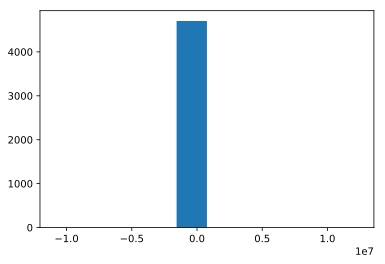

In [13]:
## histogram of SCP-entry totals for analysis
plt.hist(SCP_ENTRY_weektotals)

In [14]:
## display the highest-traffic stations for this week (all entries+ all exits)
STATION_traffic_weektotals = (SCP_ENTRY_weektotals + SCP_EXIT_weektotals).groupby(['STATION']).sum()
STATION_traffic_weektotals.sort_values(ascending=False).head(10)

STATION
36 AV              4425449.0
34 ST-PENN STA     1868658.0
GRD CNTRL-42 ST    1658821.0
34 ST-HERALD SQ    1300997.0
14 ST-UNION SQ     1220524.0
TIMES SQ-42 ST     1200810.0
FULTON ST          1078230.0
23 ST              1077668.0
42 ST-PORT AUTH     938405.0
125 ST              859117.0
dtype: float64

The day of the week was identified using dt.dayofweek. The results is an integer 0 to 6, where 0 is Monday and Sunday is 6.

In [22]:
df1['WEEKDAY']=df1['DATETIME'].dt.dayofweek

In [ ]:
Checking output

In [32]:
df1.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,ENTRY_DIFFS,EXIT_DIFFS,WEEKDAY
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,00:00:00,REGULAR,6658725,2257032,2018-06-16 00:00:00,NaN,NaN,5
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,04:00:00,REGULAR,6658747,2257036,2018-06-16 04:00:00,22.0,4.0,5
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,08:00:00,REGULAR,6658766,2257068,2018-06-16 08:00:00,19.0,32.0,5
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,12:00:00,REGULAR,6658866,2257139,2018-06-16 12:00:00,100.0,71.0,5
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,16:00:00,REGULAR,6659043,2257188,2018-06-16 16:00:00,177.0,49.0,5


In [ ]:
Calculating the total entries per week day

In [44]:
STATION_ENTRY_WEEKDAY = (df1
                  .sort_values(by=['STATION','UNIT', 'C/A', 'SCP','WEEKDAY'])[['STATION','UNIT', 'C/A', 'SCP', 'ENTRY_DIFFS','WEEKDAY']]
                  .groupby(['STATION','WEEKDAY'])['ENTRY_DIFFS']).sum()


In [ ]:
Checking output

In [43]:
STATION_ENTRY_WEEKDAY.head(50)

STATION          WEEKDAY
1 AV             0          19705.0
                 1          19830.0
                 2          22019.0
                 3          22654.0
                 4          22976.0
                 5          14160.0
                 6          14290.0
103 ST           0          31534.0
                 1          33548.0
                 2          34331.0
                 3          34151.0
                 4          32943.0
                 5          17975.0
                 6          16019.0
103 ST-CORONA    0          19034.0
                 1          19639.0
                 2          19798.0
                 3          19744.0
                 4          19823.0
                 5          13561.0
                 6          10539.0
104 ST           0           2848.0
                 1           2877.0
                 2           2907.0
                 3           2793.0
                 4           2875.0
                 5           1548.0
   

In [50]:
STATION_EXIT_WEEKDAY = (df1
                  .sort_values(by=['STATION','UNIT', 'C/A', 'SCP','WEEKDAY'])[['STATION','UNIT', 'C/A', 'SCP', 'EXIT_DIFFS','WEEKDAY']]
                  .groupby(['STATION','WEEKDAY'])['EXIT_DIFFS']).sum()



In [53]:
STATION_EXIT_WEEKDAY.head(50)

STATION          WEEKDAY
1 AV             0          22582.0
                 1          22045.0
                 2          23636.0
                 3          23732.0
                 4          24666.0
                 5          15236.0
                 6          16334.0
103 ST           0          21271.0
                 1          22400.0
                 2          22845.0
                 3          23093.0
                 4          22762.0
                 5           9952.0
                 6          10841.0
103 ST-CORONA    0          12133.0
                 1          13918.0
                 2          12764.0
                 3          13931.0
                 4          13940.0
                 5           8455.0
                 6          10194.0
104 ST           0            918.0
                 1            945.0
                 2            828.0
                 3           1006.0
                 4            917.0
                 5            390.0
   

In [58]:
df1['TOTAL_TRAFFIC']=df1['EXIT_DIFFS']+df1['ENTRY_DIFFS']

STATION_TOTAL_TRAFFIC = (df1
                  .sort_values(by=['STATION','UNIT', 'C/A', 'SCP','WEEKDAY'])[['STATION','UNIT', 'C/A', 'SCP', 'TOTAL_TRAFFIC','WEEKDAY',]]
                  .groupby(['STATION','WEEKDAY'])['TOTAL_TRAFFIC']).sum()



In [59]:
STATION_TOTAL_TRAFFIC.head(50)

STATION          WEEKDAY
1 AV             0          42287.0
                 1          41875.0
                 2          45655.0
                 3          46386.0
                 4          47642.0
                 5          29396.0
                 6          30624.0
103 ST           0          52805.0
                 1          55948.0
                 2          57176.0
                 3          57244.0
                 4          55705.0
                 5          27927.0
                 6          26860.0
103 ST-CORONA    0          31167.0
                 1          33557.0
                 2          32562.0
                 3          33675.0
                 4          33763.0
                 5          22016.0
                 6          20733.0
104 ST           0           3766.0
                 1           3822.0
                 2           3735.0
                 3           3799.0
                 4           3792.0
                 5           1938.0
   